# Постановка задачи
Необходимо провести анализ производительности алгоритмов решения задач достижимости между всеми парами вершин и с
заданным множеством стартовых вершин с регулярными ограничениями.

# Описание исследуемых решений

## Достижимость между всеми парами вершин
Имеем направленный граф, о котором можно думать, как о конечном автомате и регулярный запрос. Хотим найти все пары вершин, между которыми есть путь с заданным ограничением.

Задача решается следующим способом:
* Исходный граф преобразуется в конечным автомат
* Исходное регулярное ограничение преобразуется в конечный автомат
* Оба автомата пересекаются с помощью произведения Кронекера
* Происходит поиск транзитивного замыкания графа
* Выводятся все пары вершин, между которыми есть пути, удовлетворяющие ограничению

## Достижимость с заданным множеством стартовых вершин
Задача схожа с предыдущей, только вместо поиска всех пар вершин, мы ищем множество вершин достижимых из заданного множества. Данная задача имеет две вариации:
* Поиск достижимых вершин для каждой вершины множества. В результате набор пар вершин
* Поиск достижимых вершин для всего стартового множества. В результате набор вершин

Задача решается следующим способом:
* Исходный граф, как и регулярное ограничение преобразуются в конечный автомат
* Начинается синхронный обход в ширину обоих автоматов
* Как только все вершины графа были посещены, возвращаются вершины, достижимые из заданного множества

# Вопросы
* Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
* Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?
* На сколько решение второй задачи медленнее решения третьей при одинаковых начальных условиях?

# Описание набора данных для эксперимента

Графы в эксперименте:
* [wc](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/wc.html)
* [generations](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/generations.html#generations)
* [wine](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/wine.html#wine)
* [ls](https://jetbrains-research.github.io/CFPQ_Data/dataset/data/ls.html#ls)

Данные графы были выбраны, потому что вычислительной мощности машины не хватает на большие графы.

Регулярные выражения:
* .* - регулярное выражение, которое допускает все слова для графа
* (l1 | l2)* l2 l1
* l1 l2 l3 (l4 | l1)+
где l1, l2, l3, l4 --- наиболее часто встречающиеся метки графа

# Описание эксперимента

## Оборудование

<pre><code>
Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         39 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  8
  On-line CPU(s) list:   0-7
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz
    CPU family:          6
    Model:               142
    Thread(s) per core:  2
    Core(s) per socket:  4
    Socket(s):           1
    Stepping:            12
    CPU max MHz:         4900,0000
    CPU min MHz:         400,0000
    BogoMIPS:            4599.93
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb r
                         dtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx
                          est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnow
                         prefetch cpuid_fault epb invpcid_single ssbd ibrs ibpb stibp ibrs_enhanced tpr_shadow vnmi flexpriority ept vpid ept_ad fsgsbase tsc_adjust
                         sgx bmi1 avx2 smep bmi2 erms invpcid mpx rdseed adx smap clflushopt intel_pt xsaveopt xsavec xgetbv1 xsaves dtherm ida arat pln pts hwp hwp_
                         notify hwp_act_window hwp_epp md_clear flush_l1d arch_capabilities
Virtualization features:
  Virtualization:        VT-x
Caches (sum of all):
  L1d:                   128 KiB (4 instances)
  L1i:                   128 KiB (4 instances)
  L2:                    1 MiB (4 instances)
  L3:                    8 MiB (1 instance)
NUMA:
  NUMA node(s):          1
  NUMA node0 CPU(s):     0-7
Vulnerabilities:
  Itlb multihit:         KVM: Mitigation: VMX disabled
  L1tf:                  Not affected
  Mds:                   Not affected
  Meltdown:              Not affected
  Mmio stale data:       Mitigation; Clear CPU buffers; SMT vulnerable
  Retbleed:              Mitigation; Enhanced IBRS
  Spec store bypass:     Mitigation; Speculative Store Bypass disabled via prctl and seccomp
  Spectre v1:            Mitigation; usercopy/swapgs barriers and __user pointer sanitization
  Spectre v2:            Mitigation; Enhanced IBRS, IBPB conditional, RSB filling, PBRSB-eIBRS SW sequence
  Srbds:                 Mitigation; Microcode
  Tsx async abort:       Not affected
</code></pre>

## Замеры

Для проведения замеров была написана функция my_time, которая заданное количество раз выполняет кусок кода и выдает
среднее время выполнения и стандартное отклонение.


In [34]:
from project.graph import *
from project.rpq import *
from project.boolean_decomposition import *
from cfpq_data import generate_multiple_source
import statistics
from timeit import timeit
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from tqdm import tqdm

In [39]:
def get_frequent_nodes(graph: MultiGraph):
    temp_dict = dict()

    for i in dict(graph.edges).values():
        for j in i.values():
            if j not in temp_dict:
                temp_dict[j] = 1
            else:
                temp_dict[j] += 1

    sorted_labels = sorted(temp_dict.items(), key=lambda item: item[1], reverse=True)

    result = []
    k = 0
    for (key, _) in sorted_labels:
        if k < 4:
            result.append(key)
            k += 1
        else:
            break

    return result


def get_graphs(names):
    graphs = []

    for name in names:
        try:
            graph_path = cfpq_data.download(name)
            graph = cfpq_data.graph_from_csv(graph_path)
        except FileNotFoundError:
            print("File {name} not found".format(name=name))
            continue

        graphs.append(graph)

    return graphs


def build_regexes_by_graph(graph):
    info = get_graph_info(graph)
    frequent_nodes = get_frequent_nodes(graph)

    regex1 = '({0})*'.format('|'.join(info[2]))

    regex2 = '({0}|{1})* {1} {0}'.format(frequent_nodes[0], frequent_nodes[1])

    regex3 = '{l1} {l2} {l3} ({l4}|{l1})+'.format(
        l1=frequent_nodes[0],
        l2=frequent_nodes[1],
        l3=frequent_nodes[len(frequent_nodes) - 2],
        l4=frequent_nodes[len(frequent_nodes) - 1]
    )

    return [regex1, regex2, regex3]


def my_time(stmt, repetition):
    times = list()

    for _ in tqdm(range(repetition)):
        times.append(timeit(stmt, number=1))

    return statistics.mean(times), statistics.stdev(times)


graph_names = ['generations', 'wc', 'wine', 'ls']
graphs = get_graphs(graph_names)

sizes = dict()
regexes = dict()

for i in range(len(graph_names)):
    (v, e, l) = get_graph_info(graphs[i])
    sizes[graph_names[i]] = list(map(lambda x: x // 10, [v, v * 2, v * 3, v * 5]))
    regexes[graph_names[i]] = build_regexes_by_graph(graphs[i])


to_fixed = lambda num, digits=3 : f"{num:.{digits}f}"

repetition_num = 10

[2022-10-19 21:14:33]>INFO>Found graph with name='generations'
[2022-10-19 21:14:33]>INFO>Load archive graph_archive=PosixPath('/home/esvault/PycharmProjects/formal-lang-course/venv/lib/python3.10/site-packages/cfpq_data/data/generations.tar.gz')
[2022-10-19 21:14:33]>INFO>Unzip graph name='generations' to file graph=PosixPath('/home/esvault/PycharmProjects/formal-lang-course/venv/lib/python3.10/site-packages/cfpq_data/data/generations/generations.csv')
[2022-10-19 21:14:33]>INFO>Remove archive graph_archive=PosixPath('/home/esvault/PycharmProjects/formal-lang-course/venv/lib/python3.10/site-packages/cfpq_data/data/generations.tar.gz')
[2022-10-19 21:14:33]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2514c577c0> from path=PosixPath('/home/esvault/PycharmProjects/formal-lang-course/venv/lib/python3.10/site-packages/cfpq_data/data/generations/generations.csv')
[2022-10-19 21:14:33]>INFO>Found graph with name='wc'
[2022-10-19 21:14:34]>INFO>Load archive graph

# Ход эксперимента

## Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?

Библиотека [scipy](https://docs.scipy.org/doc/scipy/index.html) поддерживает несколько вариантов представления
разреженных матриц:
* [coo_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix)
* [csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)
* [csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html#scipy.sparse.csc_matrix)
* [lil_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html#scipy.sparse.lil_matrix)

coo_matrix, lil_matrix не подходят для эффективных матричных операций. Так что сравнивались производительности с
применением csc_matrix и csr_matrix.

Так как от выбора стартовых вершин зависит время выполнения, а хочется измерить разницу между разными представлениями матриц, зададим для каждого графа набор стартовых вершин изначально.

In [27]:
csr_results = dict()
csc_results = dict()

start_nodes = dict()
final_nodes = dict()

for k, graph in enumerate(graphs):
    name = graph_names[k]
    start_nodes[name] = generate_multiple_source(graph, 5)
    final_nodes[name] = generate_multiple_source(graph, 1)


BooleanDecomposition.matrix_converter = lambda mat: mat.tocsr()

for k, graph in enumerate(graphs):
    name = graph_names[k]

    csr_results[name] = []

    start_set = start_nodes[name]
    final_set = final_nodes[name]

    stmt1 = lambda: request_path_query(regexes[name][0], graph, start_set, final_set)
    stmt2 = lambda: rpq_bfs(regexes[name][0], graph, start_set, final_set, True)
    stmt3 = lambda: rpq_bfs(regexes[name][0], graph, start_set, final_set, False)

    r1 = my_time(stmt1, repetition_num)
    r2 = my_time(stmt2, repetition_num)
    r3 = my_time(stmt3, repetition_num)

    csr_results[name].append(r1)
    csr_results[name].append(r2)
    csr_results[name].append(r3)

BooleanDecomposition.matrix_converter = lambda mat: mat.tocsc()

for k, graph in enumerate(graphs):
    name = graph_names[k]

    csc_results[name] = []

    start_set = start_nodes[name]
    final_set = final_nodes[name]

    stmt1 = lambda: request_path_query(regexes[name][0], graph, start_set, final_set)
    stmt2 = lambda: rpq_bfs(regexes[name][0], graph, start_set, final_set, True)
    stmt3 = lambda: rpq_bfs(regexes[name][0], graph, start_set, final_set, False)

    r1 = my_time(stmt1, repetition_num)
    r2 = my_time(stmt2, repetition_num)
    r3 = my_time(stmt3, repetition_num)

    csc_results[name].append(r1)
    csc_results[name].append(r2)
    csc_results[name].append(r3)

[2022-10-19 18:35:27]>INFO>Generate set of source vertices of 5 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f25124bfca0> for multiple-source evaluation
[2022-10-19 18:35:27]>INFO>Generate set of source vertices of 1 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f25124bfca0> for multiple-source evaluation
[2022-10-19 18:35:27]>INFO>Generate set of source vertices of 5 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f256d6efdf0> for multiple-source evaluation
[2022-10-19 18:35:27]>INFO>Generate set of source vertices of 1 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f256d6efdf0> for multiple-source evaluation
[2022-10-19 18:35:27]>INFO>Generate set of source vertices of 5 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f25164f43a0> for multiple-source evaluation
[2022-10-19 18:35:27]>INFO>Generate set of source vertices of 1 nodes for graph=<networkx.class

Выведем результаты замеров в вид таблицы.

In [28]:
csr_rows = []
csc_rows = []

for name, data in csr_results.items():
    csr_rows.append([
        'csr',
        name,
        f'{to_fixed(data[0][0])}, {to_fixed(data[0][1])}', # APSP
        f'{to_fixed(data[1][0])}, {to_fixed(data[1][1])}', # BFS (True)
        f'{to_fixed(data[2][0])}, {to_fixed(data[2][1])}', # BFS (False)
    ])

for name, data in csc_results.items():
    csc_rows.append([
        'csc',
        name,
        f'{to_fixed(data[0][0])}, {to_fixed(data[0][1])}', # APSP
        f'{to_fixed(data[1][0])}, {to_fixed(data[1][1])}', # BFS (True)
        f'{to_fixed(data[2][0])}, {to_fixed(data[2][1])}', # BFS (False)
    ])

t = PrettyTable(['Matrix', 'Graph', 'APSP, dev', 'BFS, dev (True)', 'BFS, dev (False)'])
t.add_rows(csr_rows)
t.add_rows(csc_rows)
print(t)

+--------+-------------+--------------+-----------------+------------------+
| Matrix |    Graph    |  APSP, dev   | BFS, dev (True) | BFS, dev (False) |
+--------+-------------+--------------+-----------------+------------------+
|  csr   | generations | 0.120, 0.020 |   0.455, 0.050  |   0.186, 0.011   |
|  csr   |      wc     | 0.062, 0.006 |   0.087, 0.007  |   0.068, 0.006   |
|  csr   |     wine    | 0.668, 0.035 |   1.180, 0.022  |   0.811, 0.009   |
|  csr   |      ls     | 0.330, 0.010 |   0.340, 0.008  |   0.336, 0.015   |
|  csc   | generations | 0.115, 0.004 |   0.391, 0.011  |   0.186, 0.005   |
|  csc   |      wc     | 0.062, 0.006 |   0.090, 0.007  |   0.072, 0.008   |
|  csc   |     wine    | 0.688, 0.026 |   1.342, 0.122  |   0.841, 0.038   |
|  csc   |      ls     | 0.376, 0.063 |   0.370, 0.047  |   0.423, 0.081   |
+--------+-------------+--------------+-----------------+------------------+


В столбцах (APSP, dev), (BFS, dev (True)), (BFS, dev (False) указаны средние значения времени исполнения соответствующих алгоритмов со стандартным отклонением.
Исходя из полученных результатов, можно сделать вывод, что выбор матрицы (csr, csc) не влияет на быстродействие алгоритма.

# Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

Для каждого графа зафиксируем множество финальных вершин, так как его размер не влияет на производительность. Размеры стартовых множеств: \[10%, 20%, 30%, 50%\] от общего количества вершин. Для больших графов возьмем \[10%, 20%\]

In [40]:
results_true = dict()
results_apsp = dict()

BooleanDecomposition.matrix_converter = lambda mat: mat.tocsr()

for k, graph in enumerate(graphs):
    name = graph_names[k]

    results_true[name] = [[], [], []]
    results_apsp[name] = [[], [], []]

    final_nodes = generate_multiple_source(graph, 20)

    # if 'generations' or 'wc' or 'wine', sizes = [10%, 20%, 30%, 50%]
    # if 'ls', sizes = [10%, 20%]
    s = len(sizes) if k <= 2 else 2

    for i in range(s):
        start_nodes = generate_multiple_source(graph, sizes[name][i])

        for j in range(len(regexes[name])):
            stmt1 = lambda : rpq_bfs(regexes[name][j], graph, start_nodes, final_nodes, True)
            stmt2 = lambda : request_path_query(regexes[name][j], graph, start_nodes, final_nodes)

            t1, d1 = my_time(stmt1, repetition_num)
            t2, d2 = my_time(stmt2, repetition_num)

            results_true[name][j].append((t1, d1))
            results_apsp[name][j].append((t2, d2))


[2022-10-19 21:16:15]>INFO>Generate set of source vertices of 20 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2514c577c0> for multiple-source evaluation
[2022-10-19 21:16:15]>INFO>Generate set of source vertices of 12 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2514c577c0> for multiple-source evaluation
  0%|          | 0/10 [00:00<?, ?it/s]/home/esvault/PycharmProjects/formal-lang-course/venv/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|██████████| 10/10 [00:00<00:00, 14.37it/s]
[2022-10-19 21:16:32]>INFO>Generate set of source vertices of 25 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2514c577c0> for multiple-source evaluation
100%|██████████| 10/10 [00:00<00:00, 13.84it/s]
[2022-10-19 21:16:57]>INFO>Generate set of source v

Для большей наглядности выведены графики результатов.

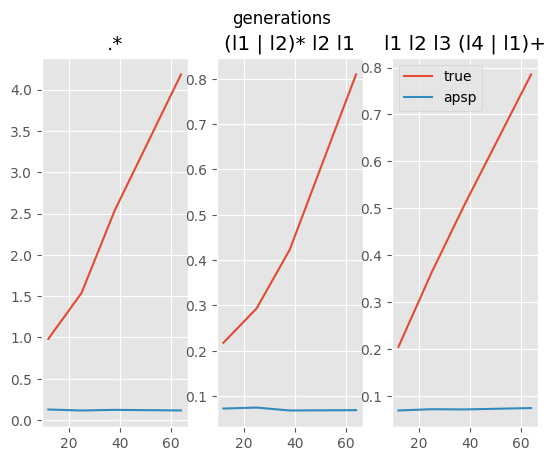

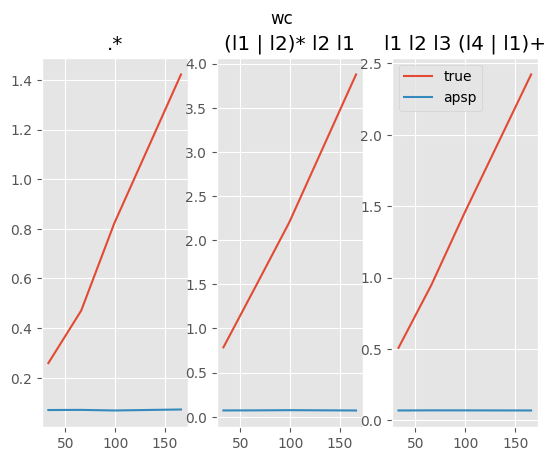

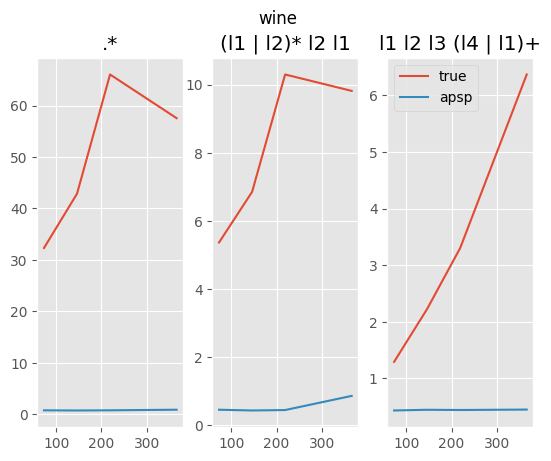

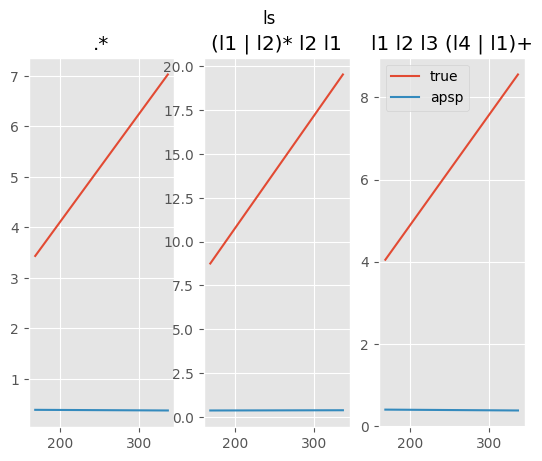

In [42]:
for k, graph in enumerate(graphs):
    name = graph_names[k]
    figure, axis = plt.subplots(1, 3)
    v, e, labels = get_graph_info(graph)

    plt.style.use('ggplot')

    slice = len(sizes) if k <= 2 else 2

    ys_true = [list(t) for t in zip(*results_true[name][0])][0]
    ys_false = [list(t) for t in zip(*results_apsp[name][0])][0]
    axis[0].plot(sizes[name][:slice], ys_true, label='true')
    axis[0].plot(sizes[name][:slice], ys_false, label='apsp')
    axis[0].set_title('.*')

    ys_true = [list(t) for t in zip(*results_true[name][1])][0]
    ys_false = [list(t) for t in zip(*results_apsp[name][1])][0]
    axis[1].plot(sizes[name][:slice], ys_true, label='true')
    axis[1].plot(sizes[name][:slice], ys_false, label='apsp')
    axis[1].set_title('(l1 | l2)* l2 l1')

    ys_true = [list(t) for t in zip(*results_true[name][2])][0]
    ys_false = [list(t) for t in zip(*results_apsp[name][2])][0]
    axis[2].plot(sizes[name][:slice], ys_true, label='true')
    axis[2].plot(sizes[name][:slice], ys_false, label='apsp')
    axis[2].set_title('l1 l2 l3 (l4 | l1)+')

    plt.suptitle(name)
    plt.legend()
    plt.show()

In [43]:
rows_true = []
rows_false = []

to_fixed = lambda num, digits=3 : f"{num:.{digits}f}"

for name, data in results_true.items():
    for i in range(len(data)):
        for j in range(len(data[i])):
            rows_true.append([name,
                              sizes[name][j],
                              ".*" if len(regexes[name][i]) > 40 else regexes[name][i],
                              f'{to_fixed(results_true[name][i][j][0])}, {to_fixed(results_true[name][i][j][1])}',
                              f'{to_fixed(results_apsp[name][i][j][0])}, {to_fixed(results_apsp[name][i][j][1])}'
                            ])

t = PrettyTable(['Name', 'Start set size', 'Regex', 'Time, dev (True)', 'Time, dev (Apsp)'])
for row in rows_true:
    t.add_row(row)
print(t)

+-------------+----------------+------------------------------------+------------------+------------------+
|     Name    | Start set size |               Regex                | Time, dev (True) | Time, dev (Apsp) |
+-------------+----------------+------------------------------------+------------------+------------------+
| generations |       12       |                 .*                 |   0.984, 0.278   |   0.128, 0.010   |
| generations |       25       |                 .*                 |   1.538, 0.035   |   0.116, 0.004   |
| generations |       38       |                 .*                 |   2.536, 0.069   |   0.124, 0.004   |
| generations |       64       |                 .*                 |   4.184, 0.080   |   0.117, 0.004   |
| generations |       12       |       (type|rest)* rest type       |   0.218, 0.012   |   0.072, 0.006   |
| generations |       25       |       (type|rest)* rest type       |   0.293, 0.010   |   0.074, 0.008   |
| generations |       38    

По результатам замеров можно сказать, что всегда выгоднее использовать алгоритм для поиска всех пар вершин и выбирать нужные, если размер стартового множества не превосходит 50% от общего количества вершин.

# На сколько решение второй задачи медленнее решения третьей при одинаковых начальных условиях?



In [44]:
results_true = dict()
results_false = dict()

for k, graph in enumerate(graphs):
    name = graph_names[k]
    # regexes = build_regexes_by_graph(graph)
    # Example: results_true['bzip'] = [[1, 2, 3], [0.5, 0.6, 0.7], [0.4, 0.6, 0.7]]
    # That means that on bzip and with regex1 algorithm executed 1s with size of start node set = 10%, separated=true
    results_true[name] = [[], [], []]
    results_false[name] = [[], [], []]
    # results_true = []
    final_nodes = generate_multiple_source(graph, 20)

    for i in range(len(sizes[name])):
        # print(sizes[i])
        start_nodes = generate_multiple_source(graph, sizes[name][i])

        for j in range(len(regexes[name])):
            stmt1 = lambda : rpq_bfs(regexes[name][j], graph, start_nodes, final_nodes, True)
            stmt2 = lambda : rpq_bfs(regexes[name][j], graph, start_nodes, final_nodes, False)

            t1, d1 = my_time(stmt1, repetition_num)
            t2, d2 = my_time(stmt2, repetition_num)

            results_true[name][j].append((t1, d1))
            results_false[name][j].append((t2, d2))

            # results_true.append(t1)
            # results_false.append(t2)



        print('End iteration for {0} nodes'.format(sizes[name][i]))


[2022-10-19 22:18:42]>INFO>Generate set of source vertices of 20 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2514c577c0> for multiple-source evaluation
[2022-10-19 22:18:42]>INFO>Generate set of source vertices of 12 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2514c577c0> for multiple-source evaluation
  0%|          | 0/10 [00:00<?, ?it/s]/home/esvault/PycharmProjects/formal-lang-course/venv/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|██████████| 10/10 [00:00<00:00, 11.24it/s]
[2022-10-19 22:19:00]>INFO>Generate set of source vertices of 25 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2514c577c0> for multiple-source evaluation


End iteration for 12 nodes


100%|██████████| 10/10 [00:00<00:00, 11.49it/s]
[2022-10-19 22:19:27]>INFO>Generate set of source vertices of 38 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2514c577c0> for multiple-source evaluation


End iteration for 25 nodes


100%|██████████| 10/10 [00:01<00:00,  9.67it/s]
[2022-10-19 22:20:11]>INFO>Generate set of source vertices of 64 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2514c577c0> for multiple-source evaluation


End iteration for 38 nodes


100%|██████████| 10/10 [00:00<00:00, 10.97it/s]
[2022-10-19 22:21:13]>INFO>Generate set of source vertices of 20 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2514950610> for multiple-source evaluation
[2022-10-19 22:21:13]>INFO>Generate set of source vertices of 33 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2514950610> for multiple-source evaluation


End iteration for 64 nodes


100%|██████████| 10/10 [00:00<00:00, 11.02it/s]
[2022-10-19 22:21:30]>INFO>Generate set of source vertices of 66 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2514950610> for multiple-source evaluation


End iteration for 33 nodes


100%|██████████| 10/10 [00:00<00:00, 10.80it/s]
[2022-10-19 22:22:05]>INFO>Generate set of source vertices of 99 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2514950610> for multiple-source evaluation


End iteration for 66 nodes


100%|██████████| 10/10 [00:00<00:00, 10.02it/s]
[2022-10-19 22:22:56]>INFO>Generate set of source vertices of 166 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2514950610> for multiple-source evaluation


End iteration for 99 nodes


100%|██████████| 10/10 [00:00<00:00, 10.59it/s]
[2022-10-19 22:24:33]>INFO>Generate set of source vertices of 20 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2501bb67d0> for multiple-source evaluation
[2022-10-19 22:24:33]>INFO>Generate set of source vertices of 73 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2501bb67d0> for multiple-source evaluation


End iteration for 166 nodes


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]
[2022-10-19 22:29:03]>INFO>Generate set of source vertices of 146 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2501bb67d0> for multiple-source evaluation


End iteration for 73 nodes


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]
[2022-10-19 22:41:52]>INFO>Generate set of source vertices of 219 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2501bb67d0> for multiple-source evaluation


End iteration for 146 nodes


100%|██████████| 10/10 [00:04<00:00,  2.35it/s]
[2022-10-19 22:51:21]>INFO>Generate set of source vertices of 366 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f2501bb67d0> for multiple-source evaluation


End iteration for 219 nodes


100%|██████████| 10/10 [00:04<00:00,  2.43it/s]
[2022-10-19 23:00:41]>INFO>Generate set of source vertices of 20 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f250175a5f0> for multiple-source evaluation
[2022-10-19 23:00:41]>INFO>Generate set of source vertices of 168 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f250175a5f0> for multiple-source evaluation


End iteration for 366 nodes


100%|██████████| 10/10 [00:03<00:00,  2.85it/s]
[2022-10-19 23:03:28]>INFO>Generate set of source vertices of 337 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f250175a5f0> for multiple-source evaluation


End iteration for 168 nodes


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]
[2022-10-19 23:07:59]>INFO>Generate set of source vertices of 506 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f250175a5f0> for multiple-source evaluation


End iteration for 337 nodes


100%|██████████| 10/10 [00:03<00:00,  2.75it/s]
[2022-10-19 23:15:15]>INFO>Generate set of source vertices of 843 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f250175a5f0> for multiple-source evaluation


End iteration for 506 nodes


100%|██████████| 10/10 [00:03<00:00,  2.79it/s]

End iteration for 843 nodes


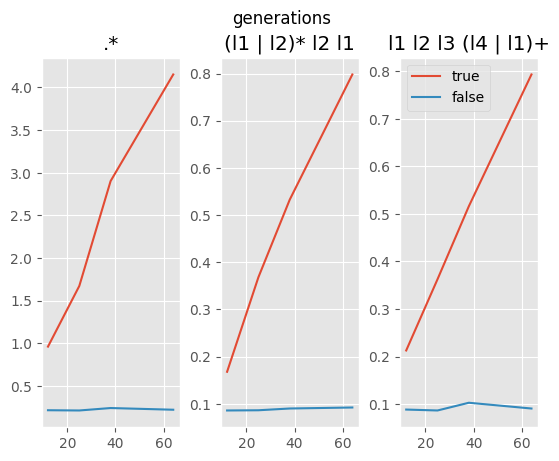

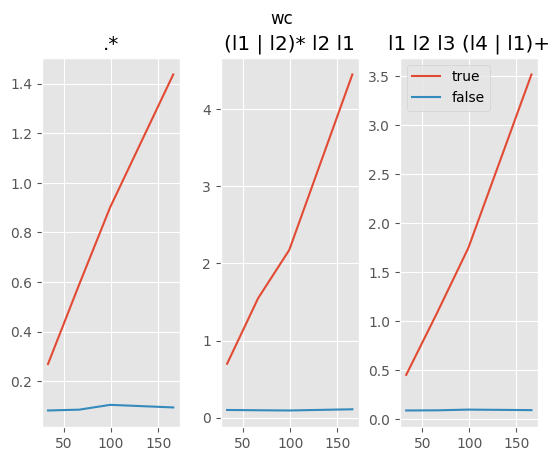

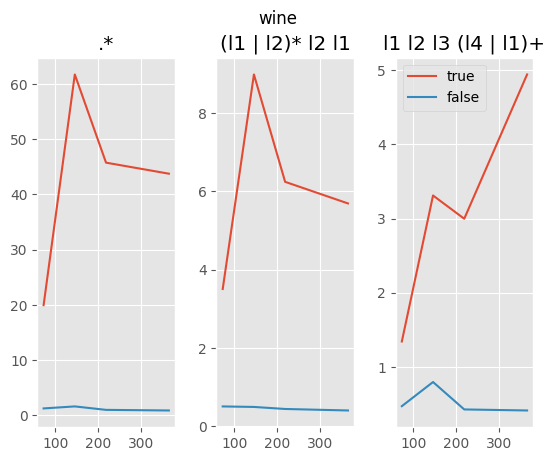

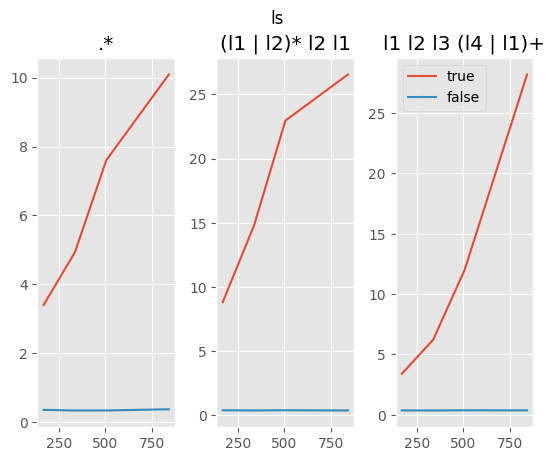

In [45]:
for k, graph in enumerate(graphs):
    name = graph_names[k]
    figure, axis = plt.subplots(1, 3)
    v, e, labels = get_graph_info(graph)

    plt.style.use('ggplot')

    ys_true = [list(t) for t in zip(*results_true[name][0])][0]
    ys_false = [list(t) for t in zip(*results_false[name][0])][0]
    axis[0].plot(sizes[name], ys_true, label='true')
    axis[0].plot(sizes[name], ys_false, label='false')
    axis[0].set_title('.*')

    ys_true = [list(t) for t in zip(*results_true[name][1])][0]
    ys_false = [list(t) for t in zip(*results_false[name][1])][0]
    axis[1].plot(sizes[name], ys_true, label='true')
    axis[1].plot(sizes[name], ys_false, label='false')
    axis[1].set_title('(l1 | l2)* l2 l1')

    ys_true = [list(t) for t in zip(*results_true[name][2])][0]
    ys_false = [list(t) for t in zip(*results_false[name][2])][0]
    axis[2].plot(sizes[name], ys_true, label='true')
    axis[2].plot(sizes[name], ys_false, label='false')
    axis[2].set_title('l1 l2 l3 (l4 | l1)+')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.suptitle(name)
    plt.legend()
    plt.show()

На графиках можно увидеть, насколько вариант алгоритма с поиском достижимых вершин для каждой вершины стартового множества медленнее второго варианта (достижимость для всего множества сразу).

In [46]:
rows_true = []
rows_false = []

for name, data in results_true.items():
    for i in range(len(data)):
        for j in range(len(data[i])):
            rows_true.append([name,
                              sizes[name][j],
                              ".*" if len(regexes[name][i]) > 40 else regexes[name][i],
                              f'{to_fixed(results_true[name][i][j][0])}, {to_fixed(results_true[name][i][j][1])}',
                              f'{to_fixed(results_false[name][i][j][0])}, {to_fixed(results_false[name][i][j][1])}'
                              ])


t = PrettyTable(['Name', 'Start set size', 'Regex', 'Time, dev (True)', 'Time, dev (False)'])
for row in rows_true:
    t.add_row(row)
print(t)


+-------------+----------------+------------------------------------+------------------+-------------------+
|     Name    | Start set size |               Regex                | Time, dev (True) | Time, dev (False) |
+-------------+----------------+------------------------------------+------------------+-------------------+
| generations |       12       |                 .*                 |   0.960, 0.254   |    0.214, 0.007   |
| generations |       25       |                 .*                 |   1.672, 0.044   |    0.211, 0.008   |
| generations |       38       |                 .*                 |   2.902, 0.124   |    0.240, 0.012   |
| generations |       64       |                 .*                 |   4.152, 0.203   |    0.220, 0.010   |
| generations |       12       |       (type|rest)* rest type       |   0.168, 0.008   |    0.086, 0.009   |
| generations |       25       |       (type|rest)* rest type       |   0.368, 0.008   |    0.086, 0.006   |
| generations |    

Исходя из результатов, алгоритм, который для каждой вершины стартового множества ищет достижимую вершину, работает медленнее, чем тот, который ищет достижимые вершины сразу для всего множества. Связано это с тем, что в реализации первого из них происходит больше матричных умножений.